# 302.2. Photometry-driven stellar properties

<div style="max-width:300px; float: left; margin-right: 1em">

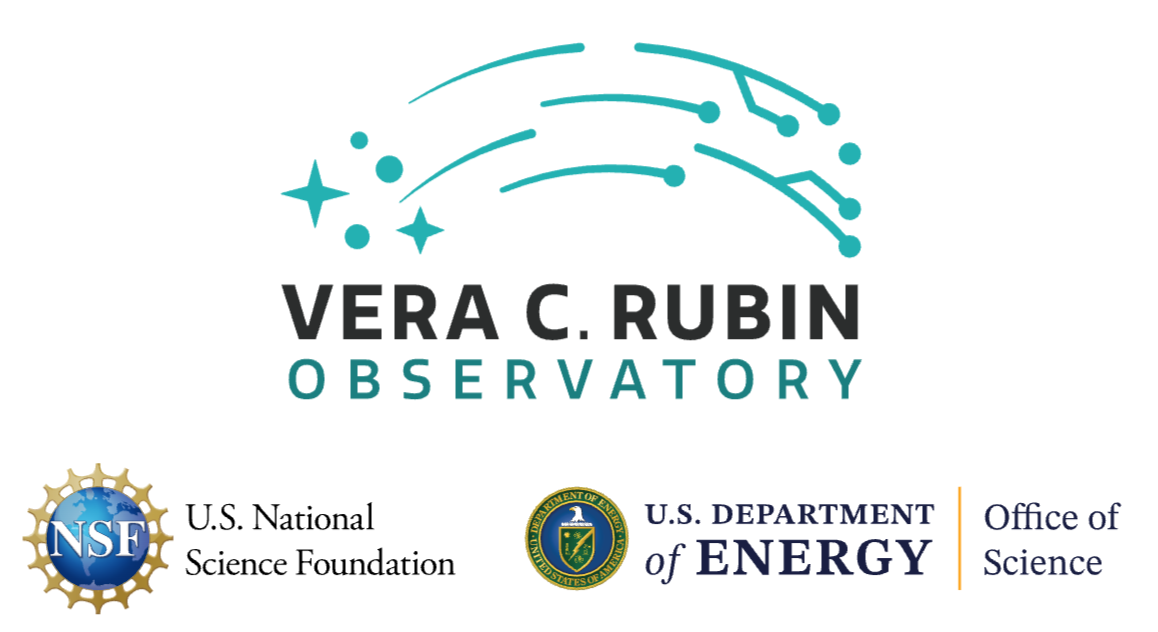

</div>

For the Rubin Science Platform at data.lsst.cloud. <br>
Data Release: <a href="https://dp1.lsst.io">Data Preview 1</a> <br>
Container Size: large <br>
LSST Science Pipelines version: r29.2.0 <br>
Last verified to run: 2025-09-19 <br>
Repository: <a href="https://github.com/lsst/tutorial-notebooks">github.com/lsst/tutorial-notebooks</a> <br>

**Learning objective:** 

**LSST data products:** `Object`

**Packages:** `lsst.rsp.get_tap_service`

**Credit:**
Originally developed by the Rubin Community Science team. Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks. 

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
import os

from lsst.rsp import get_tap_service
from lsst.daf.butler import Butler
import lsst.afw.display as afw_display
import lsst.sphgeom as sphgeom
import lsst.geom as geom
from rubin_sim.phot_utils import DustValues

In [2]:
service = get_tap_service("tap")
assert service is not None

In [3]:
ra_cen = 95.0
dec_cen = -25.0
radius = 1.0
region = sphgeom.Region.from_ivoa_pos(f"CIRCLE {ra_cen} {dec_cen} {radius}")

In [16]:
query = """
        SELECT objectId, coord_ra, coord_dec,
               u_psfMag, g_psfMag, r_psfMag, i_psfMag, z_psfMag, y_psfMag,
               ebv
        FROM dp1.Object
        WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec),
              CIRCLE('ICRS', {}, {}, {})) = 1
        AND refExtendedness = 0
        """.format(ra_cen, dec_cen, radius)

In [17]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

Job phase is COMPLETED


In [18]:
assert job.phase == 'COMPLETED'
objtab = job.fetch_result().to_table()

In [19]:
os.environ['RUBIN_SIM_DATA_DIR'] = '/rubin/rubin_sim_data'

In [20]:
bands = "ugrizy"

In [21]:
R_band = DustValues().r_x
print(R_band)

{'u': np.float64(4.757217815396922), 'g': np.float64(3.6605664439892625), 'r': np.float64(2.70136780871597), 'i': np.float64(2.0536599130965882), 'z': np.float64(1.5900964472616756), 'y': np.float64(1.3077049588254708)}


In [22]:
A_band = {band: R_band[band] * objtab['ebv'] for band in bands}

In [23]:
for band in bands:
    objtab[f"{band}_psfMag0"] = objtab[f"{band}_psfMag"] - A_band[band]

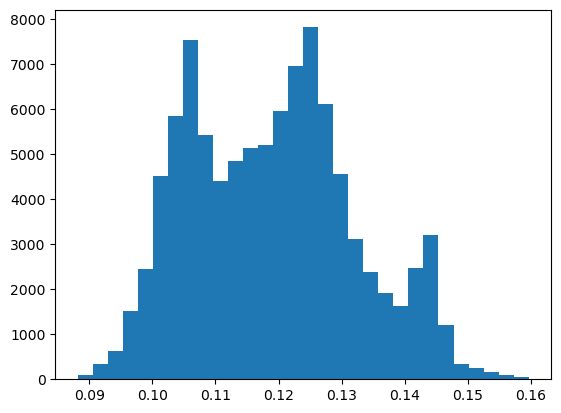

In [24]:
h = plt.hist(A_band['r'], bins=30)

In [25]:
gr_col = ((objtab['g_psfMag0']-objtab['r_psfMag0']) > 0.2) & ((objtab['g_psfMag0']-objtab['r_psfMag0']) < 0.6)
ug_gr_col = ((objtab['u_psfMag0']-objtab['g_psfMag0']) > 0.7) & ((objtab['u_psfMag0']-objtab['g_psfMag0']) < 2.0) &\
            ((objtab['g_psfMag0']-objtab['r_psfMag0'])-0.5*(objtab['u_psfMag0']-objtab['g_psfMag0']) > -0.25) &\
            ((objtab['g_psfMag0']-objtab['r_psfMag0'])-0.5*(objtab['u_psfMag0']-objtab['g_psfMag0']) < 0.05)
gr_ri_col = (0.35*(objtab['g_psfMag0']-objtab['r_psfMag0'])-(objtab['r_psfMag0']-objtab['i_psfMag0']) > -0.2) &\
            (0.35*(objtab['g_psfMag0']-objtab['r_psfMag0'])-(objtab['r_psfMag0']-objtab['i_psfMag0']) < 0.1)
mask = (A_band['r'] < 0.3) & (objtab['g_psfMag0'] > 14) & (objtab['g_psfMag0'] < 19.5) & gr_col & ug_gr_col & gr_ri_col

In [26]:
ms = objtab[mask]

In [27]:
log_Teff = 3.872 - 0.264*(ms['g_psfMag0']-ms['r_psfMag0'])

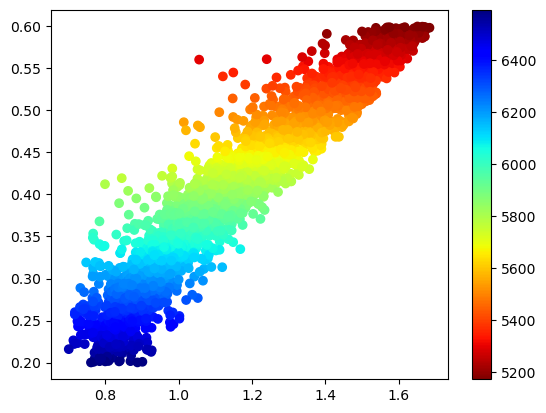

In [31]:
plt.scatter(ms['u_psfMag0']-ms['g_psfMag0'], ms['g_psfMag0']-ms['r_psfMag0'], c=10**log_Teff, cmap=plt.cm.jet_r)
plt.colorbar()

In [32]:
def feh_phot_ivezic2008(u_minus_g, g_minus_r):
    """
    Photometric metallicity [Fe/H]_ph from SDSS colors (Ivezic et al. 2008, ApJ 684, 287; Eq. 4).
    Valid for F/G dwarfs with 0.2 < (g-r) < 0.6.
    """
    ug = np.asarray(u_minus_g, dtype=float)
    gr = np.asarray(g_minus_r, dtype=float)

    x = np.where(gr <= 0.4, ug, ug - 2.0*gr + 0.8)
    y = gr

    # coefficients (A..J)
    A, B, C, D, E, F, G, H, I, J = (-4.37, -8.56, 15.5, -39.0, 23.5, 20.5, 12.1, 7.33, -10.1, -21.4)

    # Eq. (4)
    feh = (A + B*x + C*y + D*x*y + E*x**2 + F*y**2
             + G*x**2*y + H*x*y**2 + I*x**3 + J*y**3)
    return feh


In [33]:
feh_phot = feh_phot_ivezic2008(ms['u_psfMag0']-ms['g_psfMag0'], ms['g_psfMag0']-ms['r_psfMag0'])

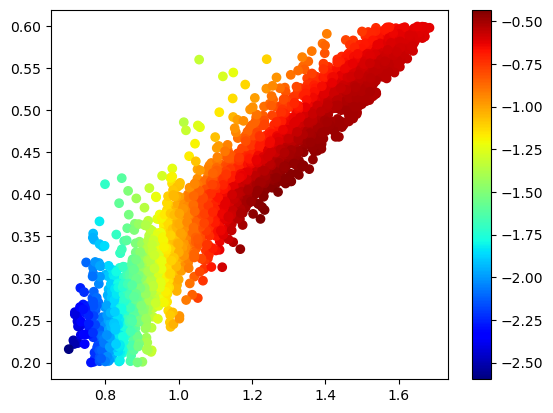

In [35]:
plt.scatter(ms['u_psfMag0']-ms['g_psfMag0'], ms['g_psfMag0']-ms['r_psfMag0'], c=feh_phot, cmap=plt.cm.jet)
plt.colorbar()

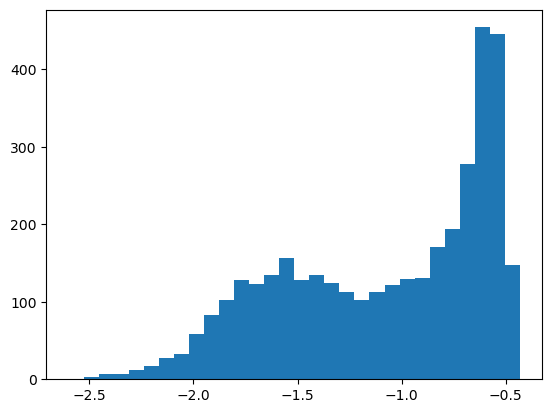

In [36]:
h = plt.hist(feh_phot, bins=30)